In [47]:
# Bibliotecas Básicas
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# FrameWork utilizado --> Pytorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Função para calculo de estatisticas de eficiencia
from sklearn.metrics import classification_report

# Pegando o Dataset pelo Keras
from keras.datasets import mnist

In [2]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

# Analise exploratoria dos dados

In [3]:
print('X_train: ' , train_X.shape)
print('Y_train: ', (train_y.shape))
print('X_test:  ', (test_X.shape))
print('Y_test:  ', test_y.shape)

X_train:  (60000, 28, 28)
Y_train:  (60000,)
X_test:   (10000, 28, 28)
Y_test:   (10000,)


Nessa database Tem-se um total de 70000 imagens de números, os quais serao separados 60000 para treinar o modelo e 10000 para testar o modelo treinado.

# DataLoader
O data Loader será utilizado para poder pegar os dados aleatoriamente e controlar o "Batch Size"

In [4]:
class MNIST(Dataset):
    
    def __init__(self,X,y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
    

In [5]:
train_dl = DataLoader(MNIST(train_X, train_y), batch_size=256)
test_dl = DataLoader(MNIST(test_X, test_y), batch_size= 64)

# Criando o Modelo de MLP

In [41]:
class MLP_Model(nn.Module):
    def __init__(self):
        super(MLP_Model,self).__init__()

        
        self.A1 = nn.Flatten()
        self.L1 = nn.Linear(28*28,80)
        self.A2 = nn.ReLU()
        self.L2 = nn.Linear(80,40)
        self.L3 = nn.Linear(40,10)
            
        
    def forward(self, x):
        
        x = self.A1(x)
        x = self.L1(x)
        x = self.A2(x)
        x = self.L2(x)
        x = self.A2(x)
        x = self.L3(x)
        
        
        return x

    

# Treinando o modelo


In [42]:
def training( N_Epochs, model, loss_fn, opt  ):
    
    loss_list = []
    
    for epoch in tqdm(range(N_Epochs+1)):
        for xb, yb in train_dl:
            
            y_pred = model(xb.float())
            loss   = loss_fn(y_pred, yb.long())
            
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            
        
        #print(epoch, "loss=", loss.item())
        loss_list.append(loss.item())
            
    
    plt.figure(figsize = (14,6))
    plt.title("cost decay")
    plt.plot(loss_list)
    plt.xlabel("epoch")
    plt.ylabel("cost")
    
    

100%|██████████| 101/101 [01:48<00:00,  1.07s/it]


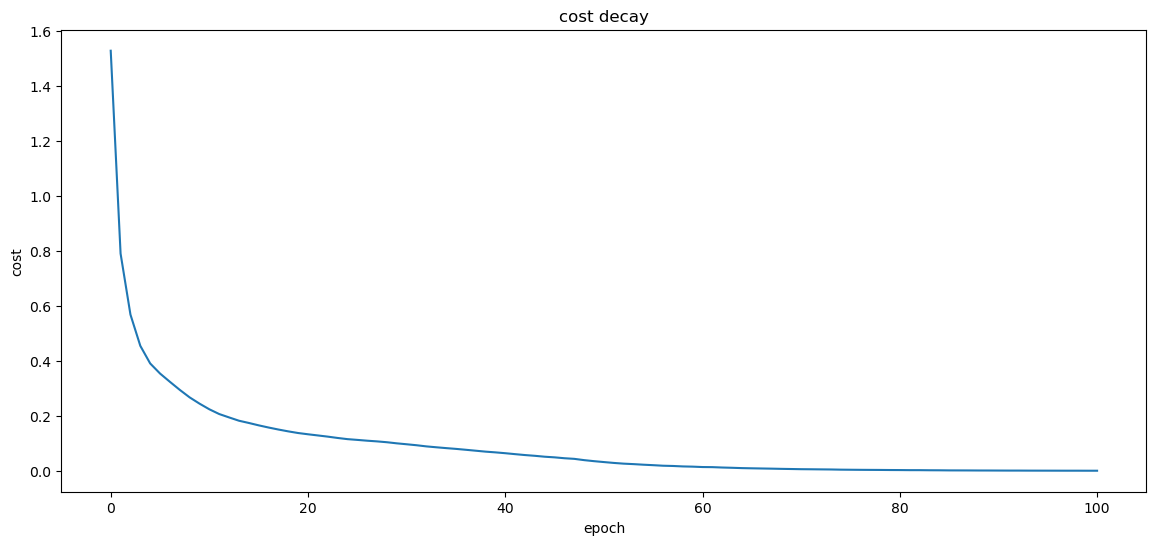

In [43]:
epoch = 100
model =  MLP_Model()
loss = nn.CrossEntropyLoss()
opt = torch.optim.Adam( model.parameters(), lr=0.00003 )
training(epoch,model, loss, opt)

# Avaliando a efetividade do Modelo

In [44]:
with torch.no_grad():
    
    model.eval()
    
    y_pred = []
    y_true = []

    for xb, yb in test_dl:
        y_predb = model(xb.float())
        y_pred.append(y_predb)
        y_true.append(yb)
        
    y_pred = torch.cat(y_pred)
    y_true = torch.cat(y_true)
  
    yf     = torch.argmax(y_pred, dim=1)

    print(classification_report(y_true, yf))        


              precision    recall  f1-score   support

           0       0.97      0.98      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.96      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.96      0.98      0.97       982
           5       0.94      0.97      0.96       892
           6       0.97      0.96      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.97      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



# Testes para otimizar o modelo

### Alterando o número de épocas  
  
epochs = 20 , lr=0.003 --> (precision,recall,f1-score) = (0.78,0.76,0.77)  
epochs = 25 , lr=0.003 --> (precision,recall,f1-score) = (0.88,0.88,0.88)  
epochs = 30 , lr=0.003 --> (precision,recall,f1-score) = (0.86,0.85,0.85)  
epochs = 50 , lr=0.003 --> (precision,recall,f1-score) = (0.89,0.89,0.88)  

### Alterando o valor do Learning rate e o número de épocas  
  
epochs = 50 , lr=0.00003 --> (precision,recall,f1-score) = (0.93,0.93,0.93)  
epochs = 60 , lr=0.00003 --> (precision,recall,f1-score) = (0.92,0.92,0.92)  
epochs = 70 , lr=0.00003 --> (precision,recall,f1-score) = (0.94,0.94,0.94)  
epochs = 100 , lr=0.00003 --> (precision,recall,f1-score) = (0.94,0.94,0.94)  

### Alterando os layers
    
epochs = 100 , lr=0.00003 , L1(28*28,40) L2(40,10) --> (precision,recall,f1-score) = (0.95,0.95,0.95)  
epochs = 100 , lr=0.00003 , L1(28*28,80) L2(80,40) L3(40,10) --> (precision,recall,f1-score) = (0.97,0.97,0.97)  


In [50]:
df = pd.read_json('Experimentos_MLP.json')
df

,epochs,learning_rate,layers,precision,recall,f1_score
0,20,0.00300,"[L1(28x28,20), L2(20,10)]",0.78,0.76,0.77
1,25,0.00300,"[L1(28x28,20), L2(20,10)]",0.88,0.88,0.88
2,30,0.00300,"[L1(28x28,20), L2(20,10)]",0.86,0.85,0.85
3,50,0.00300,"[L1(28x28,20), L2(20,10)]",0.89,0.89,0.88
4,50,0.00003,"[L1(28x28,20), L2(20,10)]",0.93,0.93,0.93
5,60,0.00003,"[L1(28x28,20), L2(20,10)]",0.92,0.92,0.92
6,70,0.00003,"[L1(28x28,20), L2(20,10)]",0.94,0.94,0.94
7,100,0.00003,"[L1(28x28,20), L2(20,10)]",0.94,0.94,0.94
8,100,0.00003,"[L1(28x28,40), L2(40,10)]",0.95,0.95,0.95
9,100,0.00003,"[L1(28x28,80), L2(80,40), L3(40,10)]",0.97,0.97,0.97
